# Taking a first look and cleaning the data.
* [Data Source](https://airtable.com/appeVUdmRBi3K9hTS/tblLywLvMA2OTesQP/viwRRKOaZvvkSNfmU?blocks=hide)
* [Term Explanations](https://docs.calitp.org/data-infra/datasets_and_tables/transitdatabase.html)

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 50
pd.options.display.max_rows = 250
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from itertools import chain
from os import path

import altair as alt
import charts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calitp import *
from PIL import Image
from shared_utils import altair_utils
from siuba import *
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


## Products Data

In [2]:
# drop columns with tons of NAs
products = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}products_May_3.csv"))
    .drop(
        columns=[
            "business_model_features",
            "attachments",
            "status",
            "certifications",
            "connectivity",
            "accepted_input_components",
            "output_components",
            "input",
            "output",
        ]
    )
    .rename(columns={"name": "product_name"})
)

In [3]:
products.columns

Index(['product_name', 'components', 'vendor', 'url', 'requirements',
       'product_features', 'notes', 'organization_stack_components'],
      dtype='object')

In [4]:
products.isna().sum()

product_name                       0
components                         9
vendor                            40
url                               70
requirements                     233
product_features                 180
notes                            173
organization_stack_components    103
dtype: int64

In [5]:
### Count number of strings by column in organization_stack_components column to see how many orgs are using this vendor.
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
products["count_of_orgs_using_product"] = (
    products["organization_stack_components"]
    .str.split(",+")
    .str.len()
    .groupby(products.product_name)
    .transform("sum")
)

In [6]:
unique_vendors = products.vendor.nunique()
f"{unique_vendors} unique vendors"

'83 unique vendors'

In [7]:
f"{products.product_name.nunique()} unique products"

'259 unique products'

In [8]:
products.sample(1)

,product_name,components,vendor,url,requirements,product_features,notes,organization_stack_components,count_of_orgs_using_product
219,IPS Sentry,Real-time info,IPS Systems,https://ips-systems.com/Home/Sentry,NaN,NaN,NaN,Free South City Shuttle-IPS Sentry-Real-time info,1.00


In [9]:
products = products.fillna("N/A")

### What % of vendors with scheduling software also provide GTFS data out of the box? 

In [10]:
# https://stackoverflow.com/questions/47125076/how-to-filter-rows-containing-specific-string-values-with-an-and-operator
gtfs_scheduling = products[
    products["components"].str.contains("GTFS")
    & products["components"].str.contains("Scheduling")
]
gtfs_scheduling[
    ["product_name", "components", "vendor", "count_of_orgs_using_product", "notes"]
]

,product_name,components,vendor,count_of_orgs_using_product,notes
128,TripShot - Unspecified,"KPI Reporting,Scheduling (Fixed-route),Scheduling (Demand-Responsive),Mobile trip planning app,Real-time info,GTFS generation",TripShot Inc.,1.00,N/A
234,Giro HASTUS,"Scheduling (Fixed-route),GTFS generation",Giro Inc.,35.00,N/A
235,The Master Scheduler,"Scheduling (Fixed-route),GTFS generation",The Master Scheduler,5.00,http://themasterscheduler.com/whitepapers/TMS2GT.pdf
236,Trapeze - Unspecified,"Scheduling (Fixed-route),GTFS generation",Trapeze Group,23.00,N/A
237,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Optibus,10.00,N/A


In [11]:
vendors_gtfs_scheduling = gtfs_scheduling.vendor.nunique()
vendors_gtfs_scheduling

5

In [12]:
f"About {(vendors_gtfs_scheduling/unique_vendors)} of vendors offer both GTFS generation and scheduling software"

'About 0.060240963855421686 of vendors offer both GTFS generation and scheduling software'

### Vendor with the most products


In [13]:
# filter out for any products w/o vendor info
no_vendor_nulls = products.loc[products["vendor"] != "N/A"]

In [14]:
no_vendor_nulls.vendor.value_counts().head(5)

Uber Inc.                     25
Luminator Technology Group    24
Genfare                       13
GMV Syncromatics Inc          10
Connexionz Inc.                9
Name: vendor, dtype: int64

### Most popular products in general
* Metric: count_of_orgs_using_product column is the count of strings delinated by comma in the organization stacks component column for each product.
    * Assume that each value is a separate organization.
* Genfare FareBox has 94 values, making it the most popular product
* Many organizations rely on "in house activity." 

In [15]:
most_popular = (
    products[
        ["product_name", "vendor", "components", "count_of_orgs_using_product", "notes"]
    ]
    .sort_values("count_of_orgs_using_product", ascending=False)
    .head(10)
    .rename(
        columns={
            "count_of_orgs_using_product": "number_of_organizations_using_the_product"
        }
    )
)

In [16]:
charts.basic_bar_chart(
    most_popular,
    "number_of_organizations_using_the_product",
    "product_name",
    "product_name",
    "Most Popular Products",
)

alt.Chart(...)

### Most popular products by component type and # of organizations 
* Break out components by comma.
* Most popular determined by count of organizations using a particularly product.
* Only keep that product.

In [17]:
products2 = products.copy()

In [18]:
# Separate out components.
components = products2["components"].str.split(",")
cols = products2.columns.difference(["components"])

products2 = products2.loc[products.index.repeat(components.str.len()), cols].assign(
    components=list(chain.from_iterable(components.tolist()))
)

In [19]:
# Strip extra quotes that appear around Security System, replace it with a neater value
products2 = products2.replace('"', "", regex=True)

In [20]:
products2["components"] = products2["components"].replace(
    {
        "Security System\n": "Security System",
    }
)

In [21]:
#filter out any products with 0 organizations in org stacks
popular_products = products2.loc[products2["count_of_orgs_using_product"] > 0 ]

In [22]:
# Only keep relevant columns, sort dataframe by A-Z using components
popular_products = products2[
    ["components", "vendor", "product_name", "count_of_orgs_using_product"]
].sort_values("components", ascending=True)

In [23]:
# Keep only the product within a component category with the highest # of organizations using this product.
# https://stackoverflow.com/questions/53842287/select-rows-with-highest-value-from-groupby
popular_products = (
    popular_products.drop_duplicates()
    .sort_values(["components", "count_of_orgs_using_product"], ascending=False)
    .groupby(["components"])
    .first()
    .reset_index()
    .rename(columns={"components": "component", "product_name": "most_popular_product"})
)

In [24]:
#sorting vendors by how many times they appear having the most customers in a component category.
popular_products.groupby("vendor").agg(
    {"component": "count", "count_of_orgs_using_product": "sum"}
).sort_values("component", ascending=False)

,component,count_of_orgs_using_product
vendor,,
N/A,8,33.00
Swiftly Inc.,7,258.00
GMV Syncromatics Inc,7,212.00
Luminator Technology Group,5,27.00
Uber Inc.,5,51.00
Trapeze Group,3,170.00
Clever Devices Ltd.,3,121.00
Genfare,3,109.00
INIT SE,3,114.00


## Components Data

In [25]:
components = to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}components_May_3.csv"))

In [26]:
components.shape

(107, 11)

In [27]:
components.isna().sum()

name                               0
aliases                           95
system                            73
location                           1
function_group                     3
description                       88
products                          36
organization_stack_components     82
example_stacks                    94
example_stacks_copy              107
properties_+_features             96
dtype: int64

In [28]:
# Count number of products within each component category.
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
components["count_of_products_in_categories"] = (
    components["products"]
    .str.split(",+")
    .str.len()
    .groupby(components.name)
    .transform("sum")
)

In [29]:
# Double Checking
components.loc[components["name"] == "APC Sensors"]

,name,aliases,system,location,function_group,description,products,organization_stack_components,example_stacks,example_stacks_copy,properties_+_features,count_of_products_in_categories
5,APC Sensors,Automatic Passenger Counters,APC,Vehicle,Operations,NaN,"RouteMatch - APC,Bishop Peak BPT Ecosystem,Centum Adetel APC ,UTA APC Sensors (Unspecified),UTA Horizontal APC Sensors,UTA Overhead APC Sensors,Connexionz APC,Iris Irma Matrix,UTA Model 30 CPU,Hella APS-B,Hella APS-R-Poe,Dilax PRT-400,Dilax IRS-320R,Dilax (Unspecified Model)","""SacRT Light Rail, e-van, SacRT GO, Elk Grove Transit Services, Folsom Stage Line, Causeway Connection, Sacramento Airport Express, SacRT Bus, SacRT Neighborhood Ride-UTA APC Sensors (Unspecified)-APC Sensors""",NaN,NaN,NaN,14.00


### Top 10 "crowded" product categories
* Count number of strings in the "products" column and group by "name" column to get total number of products in each sector.
* Real-time info is the most "crowded" category with 32 different products.
* Most categories only have one product.
* About 4 unique products in each category, when filtering out any categories with 0 products recorded.

In [30]:
f"{components.name.nunique()} unique categories"

'107 unique categories'

In [31]:
product_categories = (
    components[["name", "count_of_products_in_categories"]]
    .sort_values("count_of_products_in_categories", ascending=False)
    .rename(columns={"name": "category"})
)

In [32]:
# filter out any categories with 0 products - 36 values are empty
product_categories = product_categories[
    product_categories["count_of_products_in_categories"] > 0
]

In [33]:
f"{product_categories.count_of_products_in_categories.median()} average products per category"

'4.0 average products per category'

In [34]:
most_saturated_category = product_categories.head(10).rename(
    columns={"count_of_products_in_categories": "number of unique products"}
)

In [35]:
charts.basic_bar_chart(
    most_saturated_category,
    "number of unique products",
    "category",
    "category",
    "Most Saturated Categories",
)

alt.Chart(...)

### Function Groups
* Most of the products are under the "operations" group.

In [36]:
components.function_group.value_counts()

Operations         46
Rider info         20
Fare collection    10
Scheduling          7
Backoffice          6
Maintenance         6
IT                  4
Traffic             3
Reporting           1
Rider Info          1
Name: function_group, dtype: int64

## Contracts Data

In [37]:
contracts = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}Contracts_May_11.csv"))
    .drop(columns=["attachments", "organization_stack_components", "name"])
    .rename(
        columns={
            "type_of_contract:_functional_category": "functional_category",
            "type_of_contract:_functions": "contract_type",
        }
    )
)

In [38]:
contracts.shape

(159, 10)

In [39]:
contracts.isna().sum()

contract_holder          1
contract_vendor          1
contract_name           48
functional_category     16
contract_type           14
start_date              36
end_date               119
renewal_option          30
value                  150
notes                  111
dtype: int64

In [40]:
# First row of data is just N/A, so dropping it here.
contracts = contracts.dropna(subset=["contract_holder"])

In [41]:
f"{ contracts.contract_holder.nunique()} organizations in contracts data set"

'56 organizations in contracts data set'

In [42]:
f"{ contracts.contract_vendor.nunique()} vendors in contracts data set"

'44 vendors in contracts data set'

### 125 contracts have none/no record for renewal options, 4 auto-renews

In [43]:
contracts.renewal_option.value_counts()

None           125
Auto-renews      4
Name: renewal_option, dtype: int64

### Looking at contract duration:
* Contracts with an end date value populated, average duration is 3 years.

In [44]:
# Editing date time cols to the right data type
contracts = contracts.assign(
    start_date=pd.to_datetime(contracts.start_date, errors="coerce"),
    end_date=pd.to_datetime(contracts.end_date, errors="coerce"),
)

In [45]:
# new column for duration of contract year.
contracts["duration_of_contract_year"] = (
    (contracts["end_date"] - contracts["start_date"]).dt.days
) / 365

In [46]:
# fill in NAs with 0 and round to 0
contracts["duration_of_contract_year"] = (
    contracts["duration_of_contract_year"].fillna(0).round(0)
)

In [47]:
# new df for rows with end dates
filtered_for_end_date = contracts[contracts["end_date"].notnull()]

In [48]:
duration = (
    filtered_for_end_date.groupby("duration_of_contract_year")
    .agg({"contract_holder": "count"})
    .reset_index()
    .rename(
        columns={
            "duration_of_contract_year": "contract length",
            "contract_holder": "number_of_contracts",
        }
    )
)

In [49]:
filtered_for_end_date["duration_of_contract_year"].median()

3.0

In [50]:
len(filtered_for_end_date)

39

In [51]:
end_dates_by_quarters = (
    filtered_for_end_date.groupby(
        pd.to_datetime(filtered_for_end_date["end_date"], format="%b-%Y").dt.to_period(
            "Q"
        )
    )["contract_holder"]
    .count()
    .to_frame()
    .reset_index()
    .rename(
        columns={
            "contract_holder": "number_of_contracts",
            "end_date": "quarter of expiration",
        }
    )
)

In [52]:
end_dates_by_quarters["quarter of expiration"] = end_dates_by_quarters[
    "quarter of expiration"
].astype("str")

In [53]:
charts.basic_bar_chart(
    end_dates_by_quarters,
    "quarter of expiration",
    "number_of_contracts",
    "number_of_contracts",
    "Contract Expiration Dates",
)

alt.Chart(...)

### Separate contract type to look at elements within each contract.
* Functional category is less descriptive, looking at contract type instead.
* There are 71 different types because of all various combinations of GTFS, mobile ticketing, etc elements a contract can have. 
* Separating them out by commas might make it easier to to analyze.
* After splitting the combinations, only 32 cateogries.

In [54]:
f"{ contracts.contract_type.nunique()} unique contract types"

'71 unique contract types'

In [55]:
contracts = contracts.fillna("N/A")

In [56]:
contracts["contract_type"] = contracts["contract_type"].replace(
    {
        "Payment processor/Merchant services,Mobile ticketing": "Payment Processor or Merchant Services or Mobile Ticketing",
        "Payment processor/Merchant services": "Payment Processor or Merchant Services",
    }
)

In [57]:
# https://stackoverflow.com/questions/52575290/how-to-separate-string-into-multiple-rows-in-pandas
contract_type = contracts["contract_type"].str.split(",")
cols = contracts.columns.difference(["contract_type"])

In [58]:
contracts2 = contracts.loc[
    contracts.index.repeat(contract_type.str.len()), cols
].assign(contract_type_use=list(chain.from_iterable(contract_type.tolist())))

In [59]:
contracts2.contract_type_use.nunique()

32

In [60]:
contracts2.shape

(341, 11)

In [61]:
# just checking that everything is correct
contracts2.loc[
    contracts2["contract_type_use"] == "Payment Processor or Merchant Services"
]

,contract_holder,contract_name,contract_vendor,duration_of_contract_year,end_date,functional_category,notes,renewal_option,start_date,value,contract_type_use
19,City of Roseville,N/A,Elavon,0.00,N/A,N/A,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
38,Eastern Sierra Transit Authority,N/A,Elavon,0.00,N/A,Fare Payments,N/A,None,2018-02-01 00:00:00,N/A,Payment Processor or Merchant Services
79,San Joaquin Regional Transit District,N/A,FIS,0.00,N/A,Fare Payments,N/A,None,2015-07-01 00:00:00,N/A,Payment Processor or Merchant Services
95,Santa Cruz Metropolitan Transit District,N/A,FIS,0.00,N/A,Fare Payments,N/A,None,2017-10-13 00:00:00,N/A,Payment Processor or Merchant Services
107,Tahoe Transportation District,N/A,Square Inc.,0.00,N/A,Offboard fares,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
114,"""University of California, Davis""",N/A,TouchNet,0.00,N/A,N/A,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
117,Yuba-Sutter Transit Authority,N/A,Elavon,0.00,N/A,Fare Payments,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services



### Most common contract element
* Most contracts have an element of GTFS Generation, followed by Vehicle Locations, and Arrival Predictions.

In [62]:
most_common_contract_product = (
    contracts2.contract_type_use.value_counts()
    .to_frame()
    .reset_index()
    .rename(
        columns={
            "index": "element",
            "contract_type_use": "number_of_contracts with this element",
        }
    )
    .head(10)
)

In [63]:
charts.basic_bar_chart(
    most_common_contract_product,
    "number_of_contracts with this element",
    "element",
    "element",
    "Most Common Element in Contracts",
)

alt.Chart(...)

In [64]:
elements_only = contracts2["contract_type_use"]

In [65]:
# Word cloud from Natalie's notebook
def word_cloud_gen(df):
    test = " ".join(df).lower()
    wordcloud2 = WordCloud(
        width=800,
        height=400,
        stopwords=STOPWORDS,
        collocations=True,
        background_color="white",
    ).generate(test)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud2, interpolation="bilInear")
    plt.axis("off")
    plt.show()

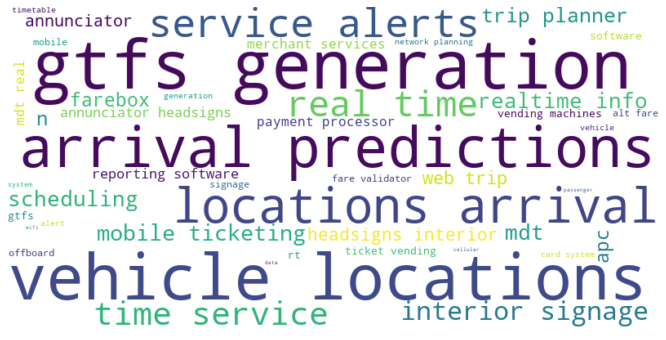

In [66]:
word_cloud_gen(elements_only)

### Most popular vendors by contract awarded

In [67]:
vendors2 = (
    contracts.contract_vendor.value_counts()
    .to_frame()
    .reset_index()
    .head(10)
    .rename(columns={"index": "vendor", "contract_vendor": "number_of_contracts"})
)

In [68]:
charts.basic_bar_chart(
    vendors2,
    "number_of_contracts",
    "vendor",
    "vendor",
    "Vendor with the Most Awarded Contracts",
)

alt.Chart(...)

### Organizations that hold the most contracts

In [69]:
contract_holders = (
    contracts.contract_holder.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "holders", "contract_holder": "# contracts"})
    .head(10)
)

In [70]:
charts.basic_bar_chart(
    contract_holders,
    "# contracts",
    "holders",
    "holders",
    "Organizations with the Most Contracts",
)

alt.Chart(...)

### Looking at contracts and their elements with end dates from May 2022 to 2024.
* Of the contracts ending, most have an element of vehicle locations and arrival predictions.

In [71]:
filtered_for_end_date.end_date.describe()

/tmp/ipykernel_4072/2493574420.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                      39
unique                     33
top       2020-06-30 00:00:00
freq                        4
first     2010-09-21 00:00:00
last      2024-06-30 00:00:00
Name: end_date, dtype: object

In [72]:
# Keep only end dates from now until 2024.
end_dates = filtered_for_end_date.loc[
    (filtered_for_end_date["end_date"] >= "2022-05-03")
]

In [73]:
len(end_dates)

9

In [74]:
end_dates[
    [
        "contract_holder",
        "functional_category",
        "contract_type",
        "start_date",
        "end_date",
        "duration_of_contract_year",
    ]
].sort_values("end_date")

,contract_holder,functional_category,contract_type,start_date,end_date,duration_of_contract_year
149,Redwood Coast Transit Authority,CAD/AVL,"Vehicle Locations,Real-time service alerts,Arrival predictions,Realtime info",2019-05-03,2022-05-03,3.00
151,Anaheim Transportation Network,Offboard rider information,Realtime info,2017-05-17,2022-05-17,5.00
152,Trinity County,"Offboard rider information,Scheduling","GTFS Generation,Web trip planner",2019-08-01,2022-07-31,3.00
153,Tuolumne County Transit Agency,"CAD/AVL,Offboard rider information","MDT,Real-time service alerts,Vehicle Locations,Arrival predictions,Web trip planner ,Realtime info",2019-05-08,2023-05-07,4.00
154,Ventura County Transportation Commission,"Offboard rider information,CAD/AVL,Onboard rider information","Headsigns,Interior signage,Annunciator,MDT,Arrival predictions,Vehicle Locations,Mobile trip planner",2017-11-03,2023-11-02,6.00
155,Yuba-Sutter Transit Authority,"CAD/AVL,Onboard rider information","Vehicle Locations,Arrival predictions,Headsigns,Interior signage",2018-11-07,2023-11-06,5.00
156,Santa Cruz Metropolitan Transit District,"Onboard rider information,Offboard rider information,CAD/AVL","Realtime info,Annunciator,Headsigns,Interior signage,MDT,Vehicle Locations,Arrival predictions,Real-time service alerts",2018-11-29,2023-11-28,5.00
157,Marin County Transit District,Scheduling,Scheduling,2019-07-01,2024-06-30,5.00
158,Monterey-Salinas Transit,"CAD/AVL,Onboard rider information,Offboard rider information","Annunciator,Interior signage,MDT,Real-time service alerts,Vehicle Locations,Arrival predictions,Offboard signage",2019-05-01,2024-06-30,5.00


## Export

with pd.ExcelWriter(f"{GCS_FILE_PATH}transit_stacks.xlsx") as writer:
    products.to_excel(writer, sheet_name="products_clean", index=False)
    popular_products.to_excel(writer, sheet_name="popular_products", index=False)
    components.to_excel(writer, sheet_name="components_clean", index=False)
    contracts.to_excel(writer, sheet_name="contracts_clean", index=False)
    contracts2.to_excel(writer, sheet_name="contracts_delineated", index=False)